# Testing GPT + Analysis

### This is just a initial project and study. I'm not a professional in this area, so I'm just trying to learn and share my knowledge. I hope you enjoy it! :)

### This is just a initial project and study. I'm not a professional in this area, so I'm just trying to learn and share my knowledge. I hope you enjoy it! :)

In [2]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

from dotenv import load_dotenv,find_dotenv

load_dotenv(find_dotenv())

True

This cell imports the libraries and the .env keys, which are needed for this project. The keys that we are using are from OpenAI and Pinecone.

The Data that we will use comes from Amazon, so I will upload it to GitHub. But you can download it from here: https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/ (Amazon Reviews Dataset) if you to get other samples. The ones that we are using here are the from the Amazon Fashion category.

In [26]:
data = []
with gzip.open('AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
        
metadata = []
with gzip.open('meta_AMAZON_FASHION.json.gz') as f:
    for l in f:
        metadata.append(json.loads(l.strip()))

Here is the explanation for the code above:

1. The first part of code is to load the Amazon Fashion dataset into a dictionary called data. 
2. The second block of code is to load the metadata for the Amazon Fashion dataset into a dictionary called metadata.

Both will be loaded in dataframes.

In [27]:
df = pd.DataFrame.from_dict(data)
df = df[df['reviewText'].notna()]

df_meta=pd.DataFrame.from_dict(metadata)

Now, we are going to truncate the reviews so that we don't process too large or unuseful data. To do this, we will limit to 400 characters on the reviewText column.

In [28]:
max_text_length=400
def truncate_review(text):
    return text[:max_text_length]

df['truncated']=df.apply(lambda row: truncate_review(row['reviewText']),axis=1)

In [29]:
df.groupby('asin').count().sort_values('overall')

,overall,verified,reviewTime,reviewerID,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,truncated
asin,,,,,,,,,,,,
0764443682,1,1,1,1,1,1,1,1,0,0,0,1
B019YM0O28,1,1,1,1,1,1,1,1,0,0,0,1
B019YME2N0,1,1,1,1,1,1,1,1,0,0,0,1
B019YMNS08,1,1,1,1,1,1,1,1,0,0,0,1
B00S7N99AY,1,1,1,1,1,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
B000PHANNM,2566,2566,2566,2566,2566,2566,2563,2566,85,2563,112,2566
B00RLSCLJM,3633,3633,3633,3633,3633,3633,3632,3633,225,3538,210,3633
B00I0VHS10,3884,3884,3884,3884,3884,3884,3880,3884,128,3872,107,3884


This cell is here just to find a product to use as an example. We will first use the second one from the bottom then the last one (from the bottom).

## Now, we will create the embeddings for the reviews and metadata.

In [30]:
df = df.loc[df['asin'] == 'B000KPIHQ4'].copy()

Here, we will use HuggingFace to create the embeddings for the reviews. This is a demo on how we can do it without OpenAI. Later, we will use OpenAI to create the embeddings.

We will create a new column and insert into the dataframe. We will use the .apply() again.

In [9]:
from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings()



In [ ]:
df['embeddings']=df.apply(lambda row: embeddings.embed_query(row['truncated']),axis=1)

In [36]:
df

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,truncated,embeddings
11218,3.0,True,"09 26, 2007",A1CIM0XZ3UA926,B000KPIHQ4,M. Cane,"Good price, good product. Howver, it is generi...",Orthotics off the rack,1190764800,2,"{'Size Name:': ' Men's 5-5.5, Women's 7-7.5', ...",NaN,"Good price, good product. Howver, it is generi...","[-0.007861480116844177, -0.006780322175472975,..."
11219,5.0,True,"01 18, 2007",A1EVVPCWRW5YYZ,B000KPIHQ4,Deborah Morris,My husband rates these insoles a 5 for comfort...,Very comfortable,1169078400,3,"{'Size Name:': ' Men's 10-10.5, Women's 12', '...",NaN,My husband rates these insoles a 5 for comfort...,"[-0.07544194161891937, 0.025455087423324585, -..."
11220,5.0,True,"05 18, 2018",A2P3NZ9H4PANK0,B000KPIHQ4,Stephanie,I have worn the Powerstep Pinnacle shoe insole...,... Pinnacle shoe insoles for the past 5 years...,1526601600,NaN,"{'Size Name:': ' Men's 6-6.5, Women's 8-8.5', ...",NaN,I have worn the Powerstep Pinnacle shoe insole...,"[-0.06397589296102524, 0.012907429598271847, -..."
11221,1.0,True,"05 18, 2018",A2975GY186VV7A,B000KPIHQ4,jessica etim,Very uncomfortable feel like I wasted my money!,Uncomfortable,1526601600,NaN,"{'Size Name:': ' Men's 7-7.5, Women's 9-9.5', ...",NaN,Very uncomfortable feel like I wasted my money!,"[-0.009998543187975883, -0.05696876347064972, ..."
11222,5.0,True,"05 17, 2018",A3U8E58RIKWDAW,B000KPIHQ4,Nancy Mazzuca,work perfect,Five Stars,1526515200,NaN,"{'Size Name:': ' Men's 9-9.5, Women's 11-11.5'...",NaN,work perfect,"[-0.01534109003841877, -0.005922211799770594, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400874,5.0,True,"05 20, 2018",A7XUE85HN4TX0,B000KPIHQ4,Kentuckymom,My podiatrist recommended these Powerstep Inso...,Superb comfort and support,1526774400,NaN,"{'Size Name:': ' Men's 6-6.5, Women's 8-8.5', ...",NaN,My podiatrist recommended these Powerstep Inso...,"[-0.05021457374095917, -0.002803092123940587, ..."
400875,3.0,True,"05 20, 2018",A1KTBKOTBM436K,B000KPIHQ4,Amazon Customer,They worked well for the first few weeks and t...,Slid around in my shoes a bit,1526774400,NaN,"{'Size Name:': ' Men's 10-10.5, Women's 12', '...",NaN,They worked well for the first few weeks and t...,"[-0.04547719657421112, 0.01694941706955433, -0..."
400876,5.0,True,"05 20, 2018",A3S84SEN2Z6DZU,B000KPIHQ4,EJ,I think these are the best.,Five Stars,1526774400,NaN,"{'Size Name:': ' Men's 7-7.5, Women's 9-9.5', ...",NaN,I think these are the best.,"[-0.029356878250837326, 0.005295349285006523, ..."
400877,5.0,True,"05 19, 2018",A3JRCF1I92QLW0,B000KPIHQ4,Amazon Customer,"With plantar fasciitis, my feet hurt all the t...","With plantar fasciitis, my feet hurt all the t...",1526688000,NaN,"{'Size Name:': ' Men's 6-6.5, Women's 8-8.5', ...",NaN,"With plantar fasciitis, my feet hurt all the t...","[-0.03282293677330017, -0.0400298610329628, -0..."


Now, with the embeddings we will create a simple random forest model to predict the rating of the product. Sparing the data into train and test. We will use scikit-learn to do this.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    list(df.embeddings.values),
    df.overall,
    test_size = 0.2,
    random_state=1
)

Lets train the model and see the results. 150 estimators should be fine.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=150)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mean_absolute_error(y_test, y_pred)

With this code, we get a mean absolute error of 0.529 (0.53). Which means that on average the prediction will be off by 53%. This is not bad, far from being good too, we could improve and do better, with some optimization or even using tensorflow/pytorch to run an advanced model, this could go below 0.3 for sure.

# Now we will introduce the embeddings in our vector database

First, lets instantiate the Pinecone environment and load the index the we inserted in the .env file.

In [5]:
import pinecone
from langchain.vectorstores import Pinecone

pinecone.init(
    api_key=os.getenv('PINECONE_API_KEY'),  
    environment=os.getenv('PINECONE_ENV')  
)

/Users/guilhermezago/Documents/GPT-Vectorized-Analysis/.venv/lib/python3.11/site-packages/pinecone/index.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Here, we transform the truncated column of our previous DF into a list of reviews (strings). This is needed to insert the vectors into the database.

In [38]:
texts=df['truncated'].tolist()

The following cell is another facility brought with the LangChain Lib. We will directly insert the vectors into the database, using the .from_texts() method, into a database the we can call whatever we want. In this case, we will call it "gpt-vector-analysis".

In [6]:
vstore = Pinecone.from_texts(texts, embeddings, index_name='gpt-vector-analysis')

NameError: name 'texts' is not defined

In [10]:
vstore = Pinecone.from_existing_index('gpt-vector-analysis', embeddings)

After the upload is complete (took about 7 minutes and 40 seconds), if we check our Pinecone Db, we should see something like the following image: 

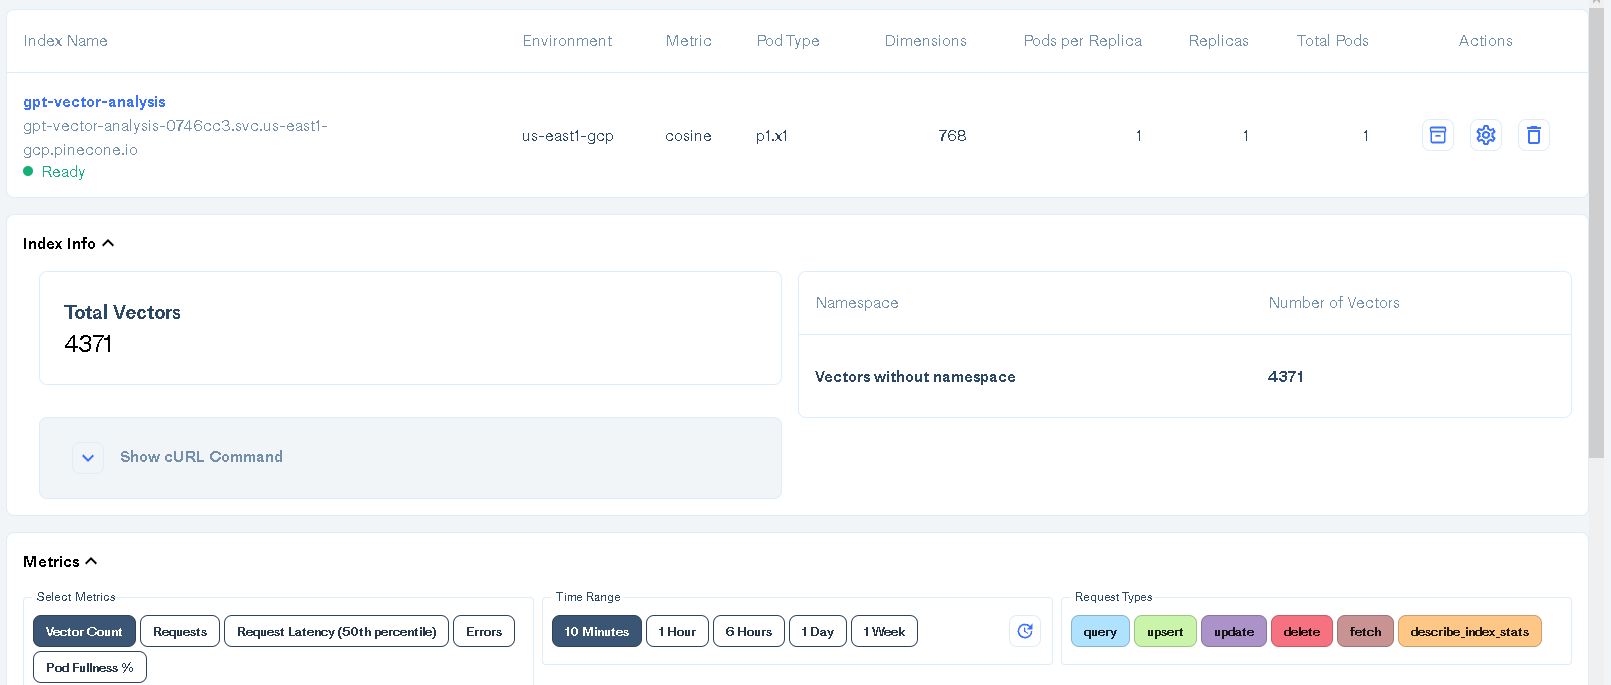

(Note that I had to manually create this Index in the Pinecone dashboard since this function doesn't create it automatically, but we are able to create and index as we see in following tests)

Here we do a simple query to check if the vectors are there. We will use the .similarity_search() method to find the contents the can match our query:

In [11]:
query = "The quality is good"
result = vstore.similarity_search(query)
print(result)

[Document(page_content='Acceptable quality. No issues', metadata={}), Document(page_content='Low quality but sometimes you get what you pay for.', metadata={}), Document(page_content='Does the job and good quality.', metadata={}), Document(page_content='Quality is everything!', metadata={})]


Now that we know that the Vector Database is working, the data is there and we can use it, Let's use the power of GPT-4 to gives us an overview, analyze, and interact with what we've built. 

### FYI:

**Chains** means easily reusable components which can be linked together.

In [12]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI

chat = ChatOpenAI(model_name="gpt-4",temperature=0.0)
review_chain = RetrievalQA.from_chain_type(llm=chat, chain_type="stuff", retriever=vstore.as_retriever())

The cell above instantiate the model of GPT-4 using the ChatOpenAI model from langchain lib (another cool way to use it) to use it by only calling the `chat`. 

And we create the `review_chain` that uses the RetrievalQA function from langchain too.

RetrievalQA is a function that is able to return the most relavant vectors when receiving a given prompt. We use the `chat` that we just created to be our *llm* method, the *chain_type* we use the `"stuff"` which means that we will stuff all the related content together and pass it as context to the LLM.

The next cell is the query that we will pass to the GPT-4 and what we will be asking to receive as response.

In [13]:
q="""
The reviews you see are for a product called 'Powerstep Pinnacle Orthotic Shoe Insoles'.
What is the overall impression of these reviews? Give most prevalent examples in bullets. 
What do you suggest we focus on improving?
"""

result=review_chain.run(q)
print(result)

Overall impression of the reviews:

- Some users found relief from foot pain and discomfort with the Powerstep Pinnacle Orthotic Shoe Insoles.
- One user mentioned that the insoles did not help with their plantar fasciitis pain.
- Another user found the arch support in the Superfeet insoles to be too high, but their father preferred them.
- A user's husband found significant improvement with the insoles and requested additional pairs.
- One user mentioned that understanding the specific foot issues is important for choosing the right insole.

Suggestions for improvement:

- Address the issue of plantar fasciitis pain relief, as one user did not find relief with the current insoles.
- Consider offering different arch support levels to accommodate various preferences and foot types.
- Provide guidance on selecting the appropriate insole based on specific foot issues and needs.


## This response shows the power of GPT-4 and a great functionallity when used with LangChain + Pinecone. This is just a simple example of what we can do with this, and we can keep expanding to a lot of other things in the whole computers world.

This could be implemented in a way that once a week, biweekly, or whatever, the automation could run and prepare a digest for a company about how the clients are feeling about each product.

# Filtered Vector Similarity Search

To be even more useful, and be capable of using even more of GPT-4s artificial intelligence, we will now separate the dataframe and create a metadatafield to do upsert in the database. We will begin by renaming some collumns and creating a new dataframe with only the columns that we need.

In [46]:
df=df.rename(columns={'embeddings':'values','reviewerID':'id'})
df['metadata']=df.apply(lambda row: dict(rating=row['overall']), axis=1)

(We will need to do this using pinecone methods, since LangChain doesn't have a method to do this yet)

In [47]:
data=df[['metadata','values','id']].to_dict(orient='records')
data_local=df[['metadata','values','reviewText','id']].to_dict(orient='records')

Here we create two copies of the dataframe, so that one is upserted and one for extracting the reviewText from ids returned from the similarity search.

In [49]:
pinecone.create_index(name='filtered', metric='euclidean', dimension=768)
index = pinecone.Index('filtered')

This is the function that we use to create a index, like I said earlier. We instantiate the just created index in the `index`.

To filter in the right way we will use the metadata that transformed in the cells above. Our upsert needs to follow a format that is specified in the documentation of Pinecone. Its like this:

```python
   vectors=[
        {
        'id':'vec1', 
        'values':[0.1, 0.2, 0.3, 0.4], 
        'metadata':{'genre': 'drama'},
           'sparse_values':
           {'indices': [10, 45, 16],
           'values':  [0.5, 0.5, 0.2]}},
        {'id':'vec2', 
        'values':[0.2, 0.3, 0.4, 0.5], 
        'metadata':{'genre': 'action'},
           'sparse_values':
           {'indices': [15, 40, 11],
           'values':  [0.4, 0.5, 0.2]}}
    ], 
    ```

Here, we upload the data in batches of 50

In [58]:
from tqdm.auto import tqdm

for i in tqdm(range(0, len(data), 50)):
    j= i + 50
    if j > len(data):
        j = len(data)
    batch = data[i: j]
    index.upsert(vectors=batch)

100%|██████████| 88/88 [00:32<00:00,  2.73it/s]


In [ ]:
query=embeddings.embed_query("will buy again")
results = index.query(queries=[query], top_k=100, filter={'rating': {'$eq': 4.0}})
print(results)

In [52]:
get_rating_from_id = {
    x['id']: {
        'rating': x['metadata']['rating'],
        'review': x['reviewText'],
    } for x in data_local}

In [53]:
def review_and_rating(query,rating):
    query=embeddings.embed_query(query)
    results = index.query(queries=[query], top_k=100, filter={'rating': {'$eq': rating}})
    ids = [i['id'] for i in results['results'][0]['matches']]
    l=[]
    for i in ids:
        l.append(get_rating_from_id[i])
    return pd.DataFrame(l)

In [54]:
repurchase_list=review_and_rating('will purchase again', 5.0)

winback=review_and_rating('disappointed', 1.0)


In [55]:
repurchase_list

,rating,review
0,5.0,Would buy again
1,5.0,"Good service, will buy again"
2,5.0,Happy with my purchase
3,5.0,Happy with purchase
4,5.0,"Great Item, I will be it buying again!"
...,...,...
95,5.0,As described. Good Transaction.
96,5.0,Excellent service and size was great.
97,5.0,Nice product and quick delivery
98,5.0,Great product.


In [56]:
winback

,rating,review
0,1.0,Not what I expected
1,1.0,Damaged
2,1.0,"Not Happy, felt like these were ""Used"" already..."
3,1.0,Uncomfortable.
4,1.0,Very disappointed. I shopped around online a l...
...,...,...
95,1.0,I bought it because I have foot pain but this ...
96,1.0,I ordered two Powerstep insoles in two differe...
97,1.0,Make sure that you know that these are right f...
98,1.0,I should have known that something wasn't righ...
